# Mondo Transaction Data Analysis

"*Built for your smartphone, this is banking like never before. One that updates your balance instantly, gives intelligent notifications and is easy to use. We’re building what we think is the best bank on the planet and want you on board.*" - https://getmondo.co.uk/

We'll all be able to analysis our own financial data using Mondos API (https://getmondo.co.uk/docs/) and a bit of help from Python. The below will load in all the transactions from your account, slice and dice the data and output the analysis.

Please feel free to fill out the MONDO_ACCESS_TOKEN and MONDO_ACCOUNT_ID and have a look into your data. These can be found on https://developers.getmondo.co.uk/.

## Imports + Setup

These will be useful later on

In [1]:
%matplotlib inline
import collections

import requests
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

from ipywidgets import widgets  

import matplotlib.pyplot as plt
from descartes import PolygonPatch
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon, Point

In [2]:
MONDO_URL = 'https://api.getmondo.co.uk'
MAP_URL = 'https://raw.githubusercontent.com/martinjc/UK-GeoJSON/master/json/electoral/eng/wpc_by_lad'

In [3]:
LONGITUDE_MIN = -0.4
LATITUDE_MIN = 51.4
LONGITUDE_MAX = 0.2 
LATITUDE_MAX = 51.65

In [4]:
MONDO_ACCESS_TOKEN = widgets.Text(placeholder='MONDO_ACCESS_TOKEN')
MONDO_ACCESS_TOKEN

In [5]:
MONDO_ACCOUNT_ID = widgets.Text(placeholder='MONDO_ACCOUNT_ID')
MONDO_ACCOUNT_ID

## Load map of London

London is split into 34 electoral zones so we will load each in turn and create a DataFrame containing the Polygons.

In [6]:
df_map = pd.DataFrame(columns=['location', 'index', 'poly'])

for i in range(1, 34):
    x = requests.get('%s/E090000%s.json' % (MAP_URL, str(i).zfill(2))).json()
    for feature in x['features']:
        name = feature['properties']['PCON13NM']
        for i, a in enumerate(feature['geometry']['coordinates']):
            df_map = df_map.append(
                {
                    'location': name, 
                    'index': i, 
                    'poly': Polygon(a[0]) if len(a) == 1 else Polygon(a)
                }, 
                ignore_index=True
            )
df_map[:5]

,location,index,poly
0,Cities of London and Westminster,0,POLYGON ((-0.150003832567287 51.48548421939302...
1,Barking,0,"POLYGON ((0.068327153038802 51.54441412626444,..."
2,Barking,1,"POLYGON ((0.129316578110982 51.5665314739179, ..."
3,Dagenham and Rainham,0,"POLYGON ((0.143178307534614 51.51532396307244,..."
4,Chipping Barnet,0,POLYGON ((-0.182110443559578 51.66860071423071...


Here are a few examples of the regions, they will all fit inside the border.

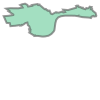

In [7]:
df_map[df_map['location'] == 'Cities of London and Westminster'].iloc[0].poly

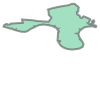

In [8]:
df_map[df_map['location'] == 'Poplar and Limehouse'].iloc[0].poly

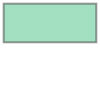

In [9]:
border_polygon = Polygon([
    (LONGITUDE_MIN, LATITUDE_MIN),
    (LONGITUDE_MIN, LATITUDE_MAX),
    (LONGITUDE_MAX, LATITUDE_MAX),
    (LONGITUDE_MAX, LATITUDE_MIN)
])
border_polygon

## Load Transaction data from Mondo

Each transaction gets loaded and assigned a point from its Longitude and Latitude.

In [10]:
headers = {'Authorization': 'Bearer ' + MONDO_ACCESS_TOKEN.value}
params = {
    'expand[]': 'merchant',
    'account_id': MONDO_ACCOUNT_ID.value
}
r = requests.get(MONDO_URL + '/transactions', params=params, headers=headers).json()

df = json_normalize(r['transactions'])
df['point'] = df.apply(lambda row: Point(row['merchant.address.longitude'], row['merchant.address.latitude']), axis=1)

Since we are going to be mapping data, we only want tranasctions which have a Longitude, Latitude, are not approximated and will be displayed within our map. We also want to throw away any declined Tranasctions since no purchase actually took place.

In [11]:
transactions = df[
    (df['merchant.address.longitude'].notnull())
    & (df['merchant.address.latitude'].notnull())
    & (df['merchant.address.approximate'] == False)
    & (df['decline_reason'].isnull())
    & (df['point'].map(lambda p: border_polygon.contains(p)))
]

Each tranasction is then assigned a region on the map. We also work out which regions we have visited.

In [12]:
def contains(point):
    for d in df_map.iterrows():    
        if d[1].poly.contains(point):
            return d[1].location

transactions['region'] = transactions['point'].map(contains)

df_map['visited'] = df_map['location'].map(lambda x: x in set(transactions['region']))
df_map[df_map['visited']][['location', 'visited']]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,location,visited
0,Cities of London and Westminster,True
55,Islington South and Finsbury,True
87,Poplar and Limehouse,True
94,Cities of London and Westminster,True


## Plotting

Now we have all the information we can begin plotting the map.

In [13]:
m = Basemap(
    projection='merc',
    llcrnrlon=LONGITUDE_MIN, 
    llcrnrlat=LATITUDE_MIN,
    urcrnrlon=LONGITUDE_MAX, 
    urcrnrlat=LATITUDE_MAX, 
    resolution='c'
)    

The map does not follow the Longitude and Latitiude so we need to translate all our regions and transactions into the map space.

In [14]:
def translate(row):
    zzz = m(
        list(row['poly'].exterior.xy[0]),
        list(row['poly'].exterior.xy[1])
    )    
    return PolygonPatch(Polygon(list(zip(*zzz))), fc='darkgreen' if row['visited'] else 'lightgray')

x, y = m(
    list(transactions['merchant.address.longitude']),
    list(transactions['merchant.address.latitude'])
)

regions = PatchCollection(
    df_map.apply(translate, axis=1), 
    match_original=True
)    

Finally the map can be created, the regions added and the transactions placed.

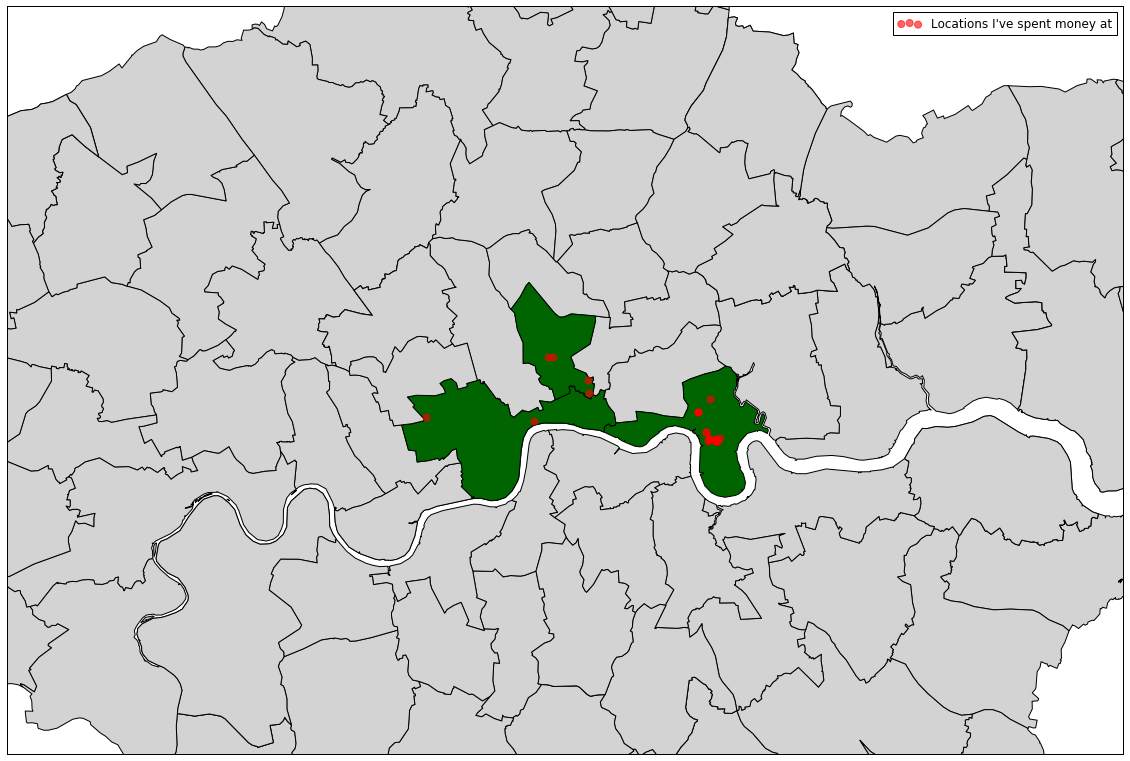

In [15]:
fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(111)

ax.add_collection(regions)

m.scatter(
    x,
    y,
    50, 
    marker='o',
    facecolor='red', 
    edgecolor='red',
    alpha=0.6, 
    label='Locations I\'ve spent money at', 
    zorder=3
)

m.drawmapboundary()
plt.legend()